In [22]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [125]:
# Importing package for KMeans algorithm
from sklearn.cluster import KMeans

# Feature extraction using SIFT
def extract_features(data):
    
    features = np.zeros((0, 128))
    
    for i in range(len(data)):
        im = data[i]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        features = np.vstack((features, des))
                
    return features

# Running k_means and getting clusters
def cluster_features(features, k=200):
    
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(features)
    return kmeans.cluster_centers_

# print(f"FEATURES:\n{features}")
# print(f"CLUSTERS:\n{clusters}")

In [279]:
def bag_of_words(clusters, data, idf=True):
    # gets bag of words for each image in data
    all_bags = []
    for i in range(len(data)):
        im = data[i] # [0]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        #print(des)
        
        # get histogram of clusters / bag of words for one image
        bag_of_words = np.zeros(len(clusters))
        for d in des:
            distances = np.linalg.norm(clusters - d, axis=1)
            bag_of_words[np.argmin(distances)] += 1
        all_bags.append(bag_of_words)
    
    if idf:
        bags_array = np.array(all_bags)
        bags_array[bags_array != 0] = 1
        
        idf_w = np.log(bags_array.shape[1] / np.sum(bags_array, axis=0))
        #print(np.min(np.log(bags_array.shape[1] / np.sum(bags_array, axis=0))))
        #print(all_bags[0])
        all_bags = [bag * idf_w for bag in all_bags]        
        #print(all_bags[0])
            
        
    return all_bags

#bags = bag_of_words(clusters, train)

In [288]:
import pandas as pd

def make_table():
    #file name, true category, training/test set, word histogram
    table = {"file_name" : [],
             "category" : [],
             "test-train" : [],
             "im" : [],
             "hist": []}
    
    #get categories
    dir_list = []
    for dirs in os.listdir("caltech-101/101_ObjectCategories/"):
        dir_list.append(os.path.join("caltech-101/101_ObjectCategories", dirs))
        
    random.Random(6).shuffle(dir_list)      
    random_categories = dir_list[:5] 

    
    #get images from each category
    for category in random_categories:
        # get files in each category
        for file in os.listdir(category):
            table["file_name"] = table.get("file_name", []) + [file]
            table["category"] = table.get("category", []) + [category.split("/")[-1]]
            im = cv2.imread(os.path.join(category, file))
            gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            table["im"] = table.get("im", []) + [gray]
            
    # shuffle data and split into train and test
    test_train = []
    
    if len(table.get("category")) % 2 == 0:
        half = int(len(table.get("category")) / 2)
        #test_train = ["test"] * half + ["train"] * half
        test_train = ["test", "train"] * half

    else:
        half = int(len(table.get("category")) / 2)
        test_train = ["test", "train"] * half + ["train"]

    #random.Random(5).shuffle(test_train)
    
    table["test-train"] = test_train
        
    return table
    
table = make_table()

train = []
test = []

for i in range(len(table["test-train"])):
    test_train = table["test-train"]
    im = table["im"]
    
    if test_train[i] == "test":
        test.append(im[i])
    elif test_train[i] == "train":
        train.append(im[i])
        
# Gather descriptors in training image data set
features = extract_features(train)
# get vocabulary
clusters = cluster_features(features, k=300)

#create bags of words for each image
table["hist"] = bag_of_words(clusters, table["im"], idf=True)

In [289]:
df_table = pd.DataFrame(table)
df_table

,file_name,category,test-train,im,hist
0,image_0055.jpg,Leopards,test,"[[1, 8, 0, 1, 3, 4, 5, 9, 4, 5, 5, 4, 2, 2, 3,...","[0.694392399968377, 0.0, 0.0, 0.31928741186711..."
1,image_0020.jpg,Leopards,train,"[[2, 2, 1, 1, 5, 3, 1, 7, 1, 1, 2, 1, 1, 0, 0,...","[0.0, 0.38077249551779285, 0.0, 0.319287411867..."
2,image_0172.jpg,Leopards,test,"[[4, 2, 1, 4, 2, 1, 1, 6, 1, 1, 2, 2, 1, 0, 0,...","[0.0, 0.38077249551779285, 0.0, 0.319287411867..."
3,image_0181.jpg,Leopards,train,"[[4, 4, 4, 4, 2, 11, 3, 4, 2, 6, 3, 2, 4, 4, 4...","[0.0, 0.0, 0.16644820763766438, 0.319287411867..."
4,image_0132.jpg,Leopards,test,"[[7, 4, 1, 1, 2, 4, 3, 1, 1, 1, 3, 3, 2, 1, 2,...","[0.694392399968377, 0.0, 0.0, 0.95786223560133..."
...,...,...,...,...,...
423,image_0014.jpg,okapi,train,"[[68, 66, 64, 61, 60, 61, 62, 63, 63, 63, 63, ...","[0.0, 0.7615449910355857, 0.0, 0.0, 0.37265915..."
424,image_0029.jpg,okapi,test,"[[35, 25, 29, 47, 54, 44, 41, 48, 38, 29, 27, ...","[1.388784799936754, 1.1423174865533785, 0.4993..."
425,image_0032.jpg,okapi,train,"[[159, 208, 228, 250, 243, 237, 254, 230, 236,...","[1.0415885999525654, 0.0, 0.16644820763766438,..."
426,image_0017.jpg,okapi,test,"[[252, 247, 253, 254, 244, 247, 247, 252, 248,...","[0.694392399968377, 0.38077249551779285, 0.166..."


In [310]:
def common_words(hist1, hist2):
    min = np.minimum(hist1, hist2)
    return -np.sum(min)

def euclidian(hist1, hist2):
    hist1 = hist1 / np.linalg.norm(hist1)
    hist2 = hist2 / np.linalg.norm(hist2)

    return np.linalg.norm(hist1 - hist2)

def bhattacharyya(hist1, hist2):
    hist1 = hist1 / np.linalg.norm(hist1)
    hist2 = hist2 / np.linalg.norm(hist2)
    
    return np.sum((hist1*hist2)**.5)

def retrieve(df,  measure, retrieve=0):
    retrieval_img = df.iloc[retrieve]
    print(retrieval_img)
    
    distances = []
    for index, row in df.iterrows():
        dist = measure(retrieval_img.loc["hist"], row.loc["hist"])
        distances.append((dist, index))
    
    distances = sorted(distances, key = lambda x:x[0])
    
    indexes = [dist[1] for dist in distances]
    
    return df_table.iloc[indexes]
        

results = retrieve(df_table, measure=euclidian, retrieve=226)
results.iloc[:40]

file_name                                        image_0045.jpg
category                                               nautilus
test-train                                                 test
im            [[153, 164, 160, 152, 153, 151, 148, 152, 149,...
hist          [2.0831771999051307, 1.1423174865533785, 0.332...
Name: 226, dtype: object


,file_name,category,test-train,im,hist
226,image_0045.jpg,nautilus,test,"[[153, 164, 160, 152, 153, 151, 148, 152, 149,...","[2.0831771999051307, 1.1423174865533785, 0.332..."
217,image_0043.jpg,nautilus,train,"[[98, 97, 96, 95, 94, 93, 93, 93, 94, 94, 94, ...","[0.3471961999841885, 0.0, 0.33289641527532876,..."
408,image_0009.jpg,okapi,test,"[[53, 57, 30, 47, 67, 113, 166, 135, 106, 161,...","[1.388784799936754, 1.9038624775889643, 0.8322..."
412,image_0018.jpg,okapi,test,"[[201, 200, 198, 200, 202, 203, 200, 198, 198,...","[0.694392399968377, 0.38077249551779285, 0.832..."
340,image_0042.jpg,elephant,test,"[[139, 131, 88, 74, 87, 74, 106, 80, 89, 91, 1...","[1.388784799936754, 0.0, 0.33289641527532876, ..."
318,image_0065.jpg,crayfish,test,"[[124, 123, 125, 129, 134, 136, 133, 130, 129,...","[0.3471961999841885, 0.38077249551779285, 0.49..."
209,image_0006.jpg,nautilus,train,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[0.0, 0.38077249551779285, 0.16644820763766438..."
401,image_0037.jpg,okapi,train,"[[82, 119, 52, 77, 108, 116, 70, 102, 133, 110...","[0.694392399968377, 0.38077249551779285, 0.166..."
249,image_0046.jpg,nautilus,train,"[[129, 129, 129, 129, 129, 129, 129, 129, 129,...","[0.3471961999841885, 1.9038624775889643, 0.332..."
220,image_0023.jpg,nautilus,test,"[[254, 254, 254, 254, 254, 254, 254, 254, 254,...","[0.694392399968377, 0.7615449910355857, 0.1664..."


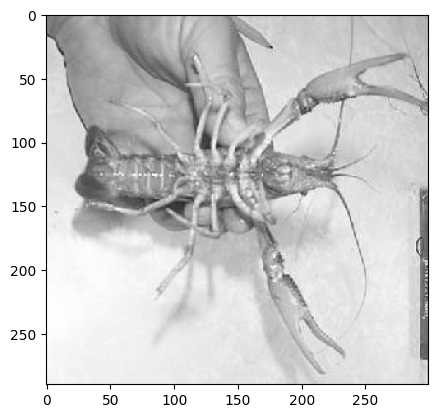

In [316]:
plt.imshow(results.iloc[5]["im"], cmap="gray", vmin=0, vmax=255)

<BarContainer object of 300 artists>

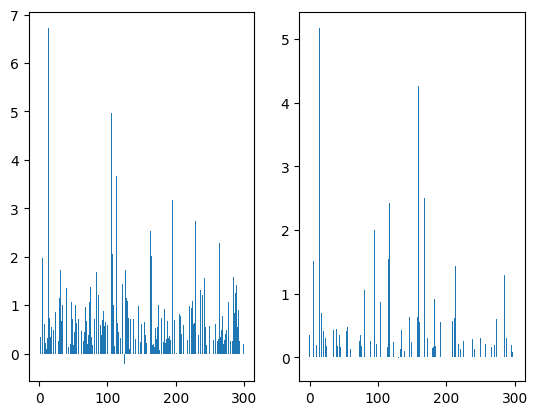

In [331]:
#plot histograms
plt.subplot(1, 2, 1)
plt.bar(np.arange(0, len(clusters)), results.iloc[0]["hist"])
plt.subplot(1, 2, 2)
plt.bar(np.arange(0, len(clusters)), results.iloc[1]["hist"])
